<h1> ______________________________________ </h1>

<h1> Single photoelectron for the setup with Na22 source </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we calculate the charge corresponding to the 511keV Na22 peak.</p>


<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> In this notebook we don't save all the waveforms, but rather work with them re-reading the files. This might take more time but less memory, preventing the laptop to collapse. </p>

-  <p style="font-size: 17px; color: black;"> 10K events per SiPM. </p>



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import math

In [3]:
import scipy
from scipy import stats, integrate
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import root, root_scalar

In [4]:
import os

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> f_cut(x, f, val): </b> To find the cut of a $f(x)$ function with a certain value $val$ we first use <b> f_cut </b> to move $f(x) \rightarrow f(x) - val$ and then find it's roots, ie, $f(x) - val = 0$. </p>


-  <p style="font-size: 17px; color: black;"> <b> resolution_eq(E, a, b, c): </b> Resolution equation to which our results should fit. </p>



In [93]:
# Gaussian
# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
# def gauss(x,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian 
#     return (x.sum()/gaussian.sum())*gaussian 


def gauss_sum2(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return gauss(x, a0,  mu0, sigma0)  + gauss(x, a1,  mu1, sigma1)



-  <p style="font-size: 17px; color: black;"> <b> wave_prep(file): </b> Take a waveform and prepare it to work with it by separating the different variables, correcting offset and possible signal saturation. </p>



In [83]:
def wave_prep(file_name, sipm, waveform_saturation = np.inf):
    
    input_file = os.path.join(path[sipm], file_name)
    
    header = {}
    header['izq'] = 12
    header['dcha'] = 14
    
    # Read the CSV file using pandas
    df = pd.read_csv(input_file, header=header[sipm])
    
    time = np.array(df['TIME']*1e6) # [us]
    signal = np.array(df['CH3']*1e3) # [mV]

    # Offsets
    offset_signal = signal[signal < 0].mean(); signal = signal - min(0., offset_signal)
    
    
    # Saturation
    signal = np.where(signal < waveform_saturation, 
                      signal,
                      signal[signal < waveform_saturation].max())
    
    return time, signal

<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [10]:
# filename = []
path = {}

init_path = '/home/investigator/mariandbt/python/data/20230801'

path['izq'] = init_path + '_1pe(izq)_temp/'
path['dcha'] = init_path + '_1pe(dcha)_temp'

-  <p style="font-size: 17px; color: black;"> Parameters to read the file. </p>

In [11]:
files = {}

In [12]:
# Get all files in the folder
files['izq'] = os.listdir(path['izq'])
files['dcha'] = os.listdir(path['dcha'])

-  <p style="font-size: 17px; color: black;"> Parameters of the read file. </p>

In [13]:
n_frames = int(len(files['izq']))
n_points = int(6250)

print('n_points = ', n_points)
print('n_frames = ', n_frames)

n_points =  6250
n_frames =  10000


<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>

 -  <p style="font-size: 17px; color: black;"> <b> patata: </b> patata. </p>
 
 


<h1> __________________________ </h1>
<h2> Analysis </h2>

<h2> Determination of the $N_{pe}$ peaks </h2>

-  <p style="font-size: 17px; color: black;"> We integrate each waveform and save said integral to calculate the charge corresponding to each photoelectron peak. </p>

In [55]:
pe_charge = {}
pe_charge['izq'] = []
pe_charge['dcha'] = []

In [71]:
file_name, sipm
len(ss), len(ss[ss < waveform_saturation])
# ss[ss < waveform_saturation].max()

(1250, 1250)

In [84]:
for sipm in ['izq', 'dcha']:
    for ii, file_name in enumerate(files[sipm]):
        
        tt, ss = wave_prep(file_name, sipm, waveform_saturation = np.inf)
        
        integr = np.trapz(ss, x=tt)
        pe_charge[sipm].append(integr)

        
    pe_charge[sipm] = np.array(pe_charge[sipm])
    print(f'Done with the SiPM from the {sipm}!')
    

/tmp/ipykernel_524559/2207191711.py:16: RuntimeWarning: Mean of empty slice.
  offset_signal = signal[signal < 0].mean(); signal = signal - min(0., offset_signal)


Done with the SiPM from the izq!
Done with the SiPM from the dcha!


- <p style="font-size: 17px; color: black;"> Waveform's integral distribution and gaussian fits.

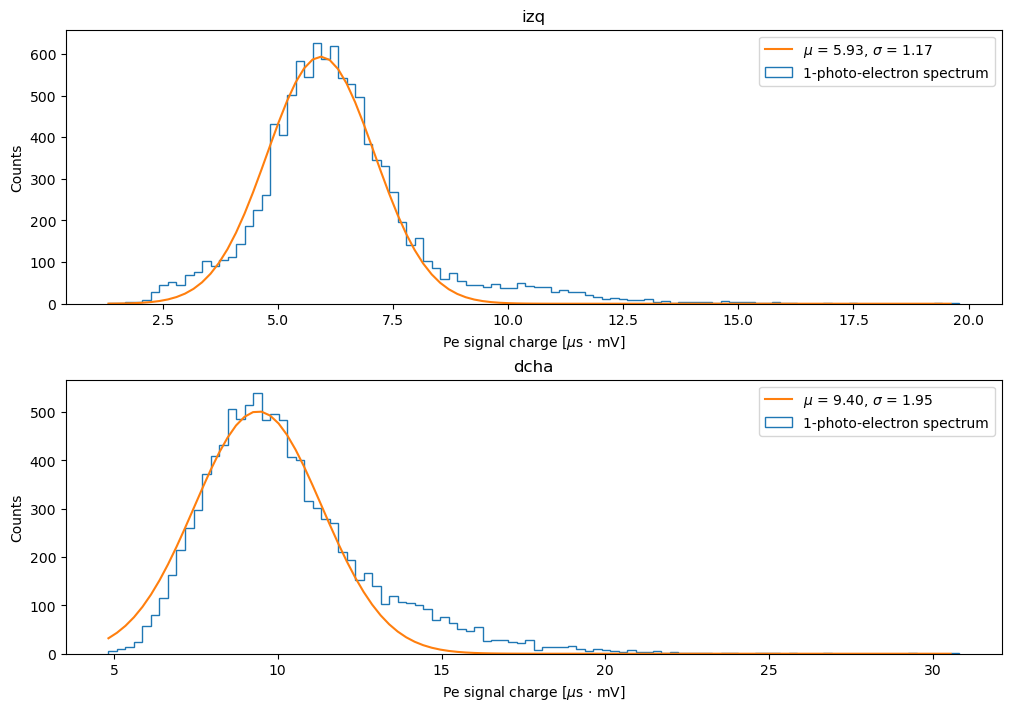

In [98]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,7), constrained_layout=True)

x_ax = {}
peaks = {}

for i, key in enumerate(['izq', 'dcha']):

    events, bins, bars = ax[i].hist(pe_charge[key], 100, 
                                 density=False, 
                                 label='1-photo-electron spectrum', 
                                 histtype='step')
    x_ax = bins[:-1]
    ev_th = 10
    
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, (bins[:-1])[events > ev_th].mean(), 1e2]) 

    a, mu, sigma = popt
    best_fit_line = gauss(x_ax, a, mu, sigma)


#_________plot_settings_________________________________________________

    ax[i].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))
    ax[i].set_xlabel(r'Pe signal charge [$\mu$s $\cdot$ mV]')
    ax[i].set_ylabel('Counts')
    ax[i].set_title(key)

    hand, labl = ax[i].get_legend_handles_labels()
    hand, labl = np.array(hand), np.array(labl)
    not_duplicated = ~pd.DataFrame(labl).duplicated()

    ax[i].legend(hand[not_duplicated], labl[not_duplicated], loc = 'best')
    # ax[i].legend(loc='best')